# 1) Coleta de Dados IPEA DATA

Os dados do PIB real foram coletados de duas formas, uma via download direto do arquivo excel e outra de uma API que traz os dados mais atualiados.


=> http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38414

## 1.1) Dados Planilha

In [43]:
# A planilha está na pasta dados.

import os
import pandas as pd
from tabulate import tabulate
diretorio = os.path.dirname(os.getcwd())
local_arquivo = os.path.join(diretorio,
                             'dados',
                             'PIB preços Basico e Preços de Mercado Deflacionados IPCA.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo)

#selecionando a coluna PIB a preços de marcado deflacionado pelo IPCA
pib_pm_deflacionado_ipca = dataframe['PIB  precos de mercado IPCA']

#As datas dos arquivo ipeadata não são reconhecidos como data pelo python.
#Abaixo crio uma serie de datas trimestrais e a incluo como indice (index) do dataframe pib_pm_deflacionado_ipca
index = pd.date_range('1996-03',
                      periods=len(pib_pm_deflacionado_ipca),
                      freq='Q')
pib_pm_deflacionado_ipca.index = index

#descomente a linha abaixo pra printar a serie
#pib_pm_deflacionado_ipca

# 2) Dessazonalizar Série

Abaixo coloquei a documentação do ajuste de sazonalidade x13
https://www.statsmodels.org/stable/generated/statsmodels.tsa.x13.x13_arima_analysis.html

In [44]:
# Pacote statsmodels que possui o x13
import statsmodels.tsa as sm

#precisei baixar um arquivo do site census pra poder a ajuste ser feito
#abaixo esta o site e o stackoverflow tirando duvidas sobre como fazer funcionar o ajuste no pyhton
#https://www.census.gov/srd/www/x13as/
#https://stackoverflow.com/questions/32053770/arima-seasonal-prediction-with-python-x12a-and-x13as-not-found-on-path

#coloquei o aquivo no numa pasta chamada x13 dentro do diretorio do notebook
local_x13_seassonal_file = os.path.join(diretorio,
                                        'notebook',
                                        'x13',
                                        'x13as')

#execução do ajuste
pib_pm_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(pib_pm_deflacionado_ipca,x12path=local_x13_seassonal_file)

dataframe_pib_pm_deflacionado_ipca_dessazonalizado = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado.seasadj)
#Descomente para printar o ajuste
#pib_pm_deflacionado_ipca_dessazonalizado.seasadj


## 2.1 Plot das Series

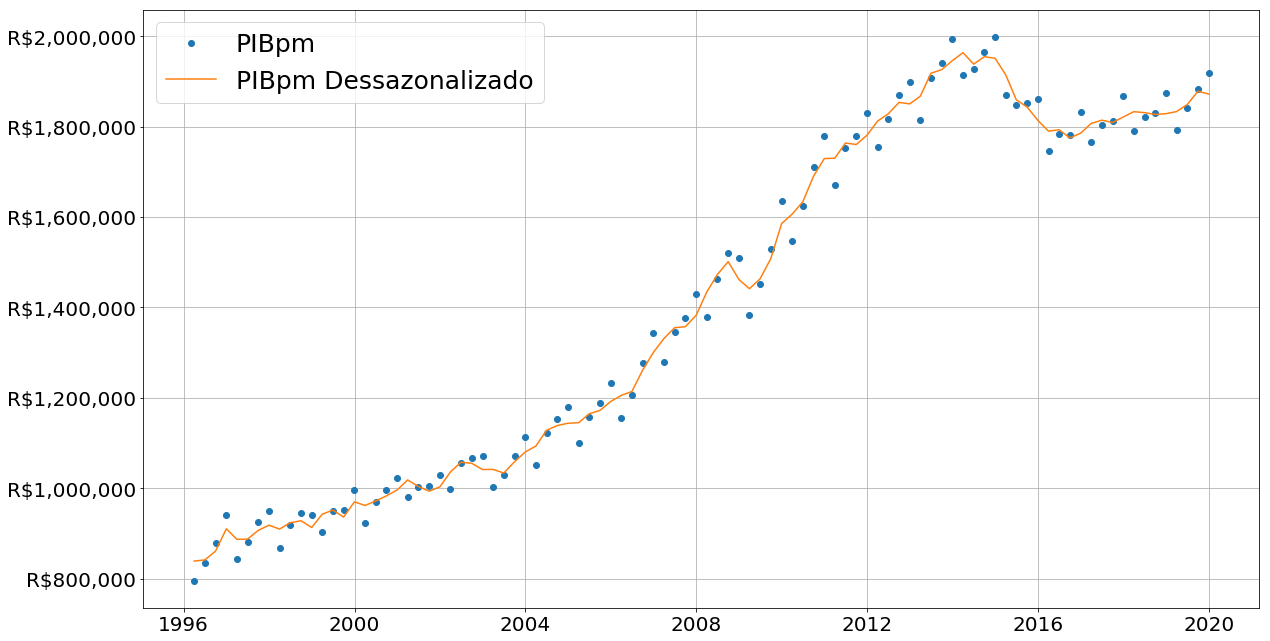

In [45]:
#pacotes de gráficos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
fmt = 'R${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot da Serie original
ax.plot(pib_pm_deflacionado_ipca.index,
        pib_pm_deflacionado_ipca.values,'o',label='PIBpm')

# Plot da Serie Com Ajuste Sazonal
ax.yaxis.set_major_formatter(tick) 
ax.plot(pib_pm_deflacionado_ipca_dessazonalizado.seasadj.index,
        pib_pm_deflacionado_ipca_dessazonalizado.seasadj.values,label='PIBpm Dessazonalizado')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",fontsize=25)


# 3) Aplicando Filtro Band Pass - Baxter and King
https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_filters.html
No call que fizemos eu nao me lembrava onde tinha visto sobre esse filtro. 
https://www.researchgate.net/publication/24111493_Measuring_Business_Cycles_The_Real_Business_Cycle_Approach_and_Related_Controversies

Quando comecei o a rodar os modelos em 2016 eu ja conhecia esse filtro, mas se não me engano na época eu perdia parte inicial e final da amostra. Mas tinha compreendido errado o que é calibração. Se entendi bem a ideia desses tipos de modelos DSGE é replicar o primeiro e o segundo momento o mais proximo da realidade da amostra.


Site com explicações do pacote
https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.bk_filter.bkfilter.html

In [68]:
# Pacode de Display de tabela em HTML
from IPython.core.display import display, HTML
#Pacote com o filtro Baxter King => sm.filters.bk_filter.bkfilter()
# pib_pm_deflacionado_ipca_dessazonalizado.seasadj é o resultado do ajuste x13
# seasadj chama os objeto com as datas e os valores
# low = O período mínimo para oscilações. Baxter e King sugerem que o ciclo de negócios calculados por Burns-Mitchell nos EUA tenha 6 para dados trimestrais e 1,5 para dados anuais.
# high = Período máximo para oscilações BK sugere que o ciclo de negócios nos EUA tenha 32 para dados trimestrais e 8 para dados anuais.
pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk = sm.filters.bk_filter.bkfilter(pib_pm_deflacionado_ipca_dessazonalizado.seasadj,
                                                                                     low=6,
                                                                                     high=32,
                                                                                     K=12)




# o retorno é um vetor [array] com os compnetes ciclicos serie x. Descomente a linhade baixo para printar
df_pib_filtrado = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk)
# Dando nome a coluna de datas
df_pib_filtrado.index.name = "Data"
# transformando a tabela em HTML 
pib_filtrado_tabela_HTML = tabulate(df_pib_filtrado, tablefmt="html")
# descomente para printar a tabela
#display(HTML(pib_filtrado_tabela_HTML))

# 3) Aplicando Filtro Christiano Fitzgerald asymmetric, random walk filter.

In [79]:
pib_cf_filter_cycle_cf, pib_cf_filter_trend_cf = sm.filters.cf_filter.cffilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'],
                                           low=6,
                                           high=32,
                                           drift=True)

# 4) Aplicando Filtro HP simples

In [80]:
pib_cf_filter_cycle_hp, pib_cf_filter_trend_hp = sm.filters.hp_filter.hpfilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'], 1600)

# Plot do componente Ciclico do PIB Real Dessazonalizado 1999:T1-2016:T4

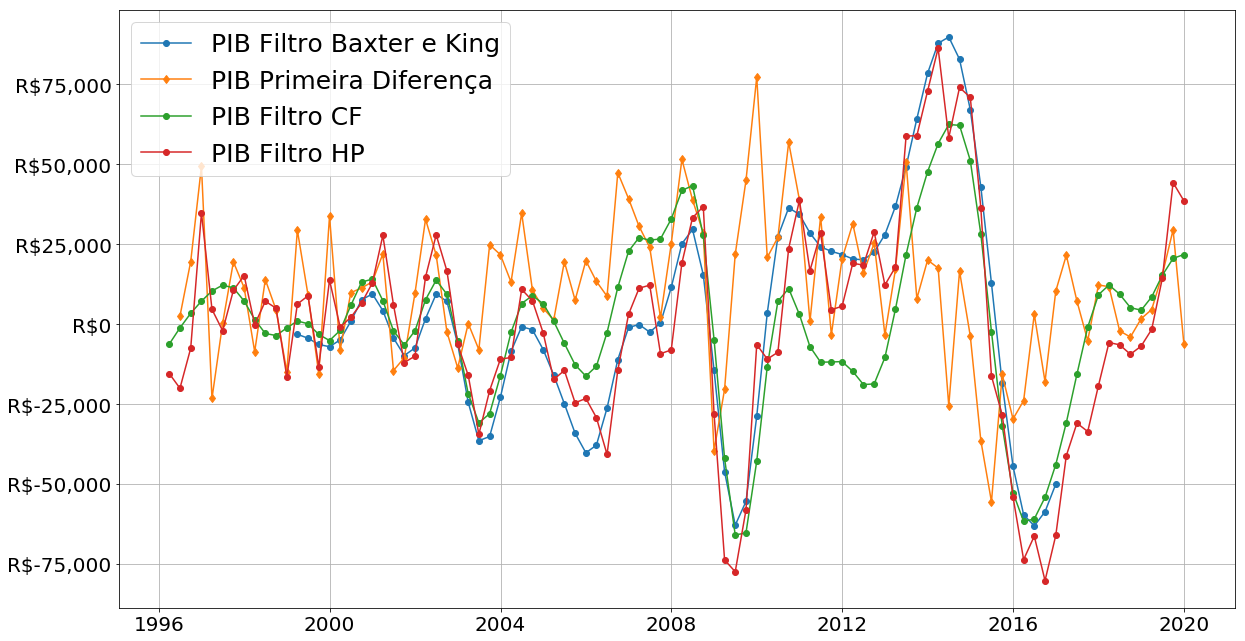

In [78]:
fmt = 'R${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk.index,
        pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk.values,'-o',label='PIB Filtro Baxter e King')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'].diff().index,
        dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'].diff().values,'-d',label='PIB Primeira Diferença')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald asymmetric, random walk filter.
ax.plot(pib_cf_filter_cycle_cf.index,
        pib_cf_filter_cycle_cf.values,'-o',label='PIB Filtro CF')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro HP.
ax.plot(pib_cf_filter_cycle_hp.index,
        pib_cf_filter_cycle_hp.values,'-o',label='PIB Filtro HP')


# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",fontsize=25)